In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import emcee
import os

G = 4.3e-6 # kpc • (km/s)² / M_⊙

In [2]:
def v_plummer(r, M, b):
    return np.sqrt(G * M * r**2 / (r**2 + b**2)**(1.5))

def v_nfw(r, A, r_s):
    r_safe = np.maximum(r, 1e-10)
    r_s_safe = np.maximum(r_s, 1e-10)
    term = (4 * np.pi * G * A) * ((1/r_safe) * np.log(1 + r_safe/r_s_safe) - 1/(r_s_safe + r_safe))
    term = np.maximum(term, 0)
    return np.sqrt(term)

def v_total_model(r, theta):
    """
    Velocidad Total = sqrt(Halo^2 + Disco^2)
    theta: [A, r_s, M_d, b_d]
    """
    A, r_s, M_d, b_d = theta
    
    v_halo = v_nfw(r, A, r_s)
    v_disk = v_plummer(r, M_d, b_d)
    
    return np.sqrt(v_halo**2 + v_disk**2)

In [ ]:
def log_prior(theta):
    # Parametros según el modelo (NFW o ISO)
    # Suponiendo ISO: [rho0, r_c, M_d, b_d]
    p1, p2, M_d, b_d = theta 
    
    # 1. Límites Físicos (Hard bounds)
    if not (0 < p1 < 1e11 and 0.1 < p2 < 100 and 0 < M_d < 1e12 and 0.1 < b_d < 20):
        return -np.inf

    # 2. Prior Informativo para el disco (Soft constraints)
    # Forzamos b_d a estar cerca de 2.0 kpc con desviación de 1.0 kpc
    mu_b = 2.0 
    sigma_b = 1.0
    log_prob_b = -0.5 * ((b_d - mu_b) / sigma_b)**2
    
    return log_prob_b

def log_likelihood(theta, r, v_obs, v_err):
    """
    Calcula qué tan bien ajusta el modelo a los datos (Chi-cuadrado).
    """
    # Verificamos primero el prior para no calcular modelos imposibles
    if not np.isfinite(log_prior(theta)):
        return -np.inf

    v_model = v_total_model(r, theta)
    
    # Chi-squared: sum((obs - model)^2 / err^2)
    # Se añade el término log(err^2) para completitud estadística, aunque es cte aquí.
    sigma2 = v_err**2
    return -0.5 * np.sum((v_obs - v_model)**2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_probability(theta, r, v_obs, v_err):
    """
    Posterior = Prior + Likelihood
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, v_obs, v_err)

# --- 3. FUNCIÓN DE AJUSTE PREVIO (LEAST SQUARES) ---
def get_starting_guess(r, v_obs, v_err):
    """
    Usa optimización rápida para encontrar un punto de partida para MCMC.
    """
    def residuals(theta):
        # Penalización suave si se sale de rangos físicos básicos
        if np.any(theta < 0): return np.inf 
        return (v_obs - v_total_model(r, theta)) / v_err

    # A, r_s, M_d, b_d
    initial_guess = [1e7, 10.0, 1e9, 1.5] 
    bounds = ([0, 0, 0, 0.1], [np.inf, 200, np.inf, 50]) # Limites inferiores y superiores
    
    res = least_squares(residuals, initial_guess, bounds=bounds, loss='soft_l1')
    return res.x

You must install the tqdm library to use progress indicators with emcee


--- Analizando: data_lsb/F563-1_rotmod.dat ---
Ejecutando Least Squares para encontrar punto inicial...
Punto de partida (Least Squares):
A=1.30e+10, rs=12.77, M_d=5.23e+09, b_d=11.39
Corriendo MCMC...

--- Resultados Finales (Mediana +/- 1 sigma) ---
A: 7.095e+10 (+2.065e+10 / -2.688e+10)
r_s: 4.838e+01 (+1.193e+01 / -1.293e+01)
M_d: 1.036e+10 (+8.407e+09 / -5.726e+09)
b_d: 4.168e+00 (+7.803e-01 / -8.376e-01)


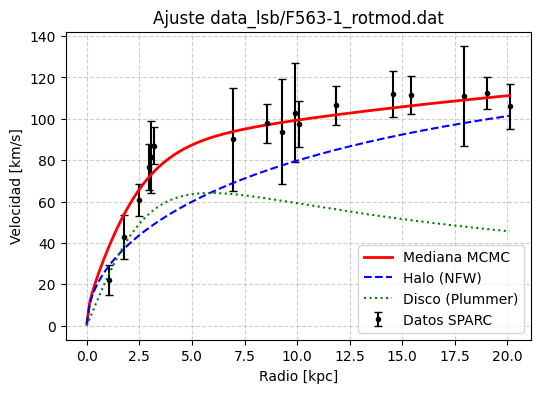

In [ ]:
def analizar_galaxia(filename):
    print(f"--- Analizando: {filename} ---")
    
    data = np.loadtxt(filename) # Si falla, prueba pd.read_csv con sep='\s+'
    r = data[:, 0]
    v_obs = data[:, 1]
    v_err = data[:, 2]


    # B. Punto de partida (Maximum Likelihood Estimation)
    theta_mle = get_starting_guess(r, v_obs, v_err)
    print(f"Punto de partida (Least Squares):")
    print(f"A={theta_mle[0]:.2e}, rs={theta_mle[1]:.2f}, M_d={theta_mle[2]:.2e}, b_d={theta_mle[3]:.2f}")

    # C. Configuración MCMC
    ndim = 4  # A, r_s, M_d, b_d
    nwalkers = 32
    nsteps = 10000
    burn_in = 1000 # Pasos a descartar al inicio

    # Inicializar walkers en una bola pequeña alrededor del resultado de Least Squares
    # pos = theta_mle + 1e-4 * theta_mle * np.random.randn(nwalkers, ndim)
    
    # Definimos "a mano" un punto de partida donde r_s sea grande
    # A grande, r_s grande (40 kpc), M_d moderado, b_d normal (5 kpc)
    guess_manual = [5e8, 40.0, 1e10, 5.0] 

    # Inicializar walkers alrededor de este punto
    pos = guess_manual + 1e-2 * np.array(guess_manual) * np.random.randn(nwalkers, ndim)

    # Asegurar que la bola inicial esté dentro de los priors (valores positivos)
    pos = np.abs(pos) 

    # D. Correr MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r, v_obs, v_err))
    
    print("Corriendo MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)

    # E. Resultados y Visualización
    # Aplanar la cadena y descartar burn-in
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)
    
    labels = [r"A", r"r_s", r"M_d", r"b_d"]
    
    # # 1. Corner Plot
    # fig = corner.corner(
    #     flat_samples, 
    #     labels=labels, 
    #     truths=theta_mle,
    #     show_titles=True,
    #     title_fmt=".2e", # Formato científico para números grandes
    #     quantiles=[0.16, 0.5, 0.84]
    # )
    # plt.savefig(f"{filename}_corner.png")
    # plt.close()

    # F. Reporte Numérico
    print("\n--- Resultados Finales (Mediana +/- 1 sigma) ---")
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        print(f"{labels[i]}: {mcmc[1]:.3e} (+{q[1]:.3e} / -{q[0]:.3e})")

    # 2. Ajuste vs Datos
    plt.figure(figsize=(6, 4))
    
    # Plotear una muestra aleatoria de modelos de la cadena posterior (para ver incertidumbre visual)
    # inds = np.random.randint(len(flat_samples), size=100)
    r_plot = np.linspace(0.001, max(r), 150)
    
    # for ind in inds:
    #     sample = flat_samples[ind]
    #     plt.plot(r_plot, v_total_model(r_plot, sample), "k", alpha=0.1)
    
    # Datos
    plt.errorbar(r, v_obs, yerr=v_err, fmt=".k", capsize=3, label="Datos SPARC")
    
    # Mejor ajuste (mediana)
    theta_median = np.median(flat_samples, axis=0)
    plt.plot(r_plot, v_total_model(r_plot, theta_median), "r", lw=2, label="Mediana MCMC")
    
    # Componentes individuales (usando la mediana)
    plt.plot(r_plot, v_nfw(r_plot, theta_median[0], theta_median[1]), "b--", label="Halo (NFW)")
    plt.plot(r_plot, v_plummer(r_plot, theta_median[2], theta_median[3]), "g:", label="Disco (Plummer)")

    plt.xlabel("Radio [kpc]")
    plt.ylabel("Velocidad [km/s]")
    plt.title(f"Ajuste {filename}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    # plt.savefig(f"{filename}_fit.png")
    plt.show()

# --- EJECUCIÓN ---
if __name__ == "__main__":
    archivos = [
    'data_lsb/F563-1_rotmod.dat',
    # 'data_lsb/F563-V2_rotmod.dat',
    # 'data_lsb/F568-1_rotmod.dat',
    # 'data_lsb/F568-3_rotmod.dat',
    # 'data_lsb/F568-V1_rotmod.dat',
    # 'data_lsb/F571-8_rotmod.dat',
    # 'data_lsb/F574-1_rotmod.dat',
    # 'data_lsb/F579-V1_rotmod.dat',
    # 'data_lsb/F583-1_rotmod.dat',
    # 'data_lsb/F583-4_rotmod.dat',
    # 'data_lsb/UGC05750_rotmod.dat',
    # 'data_lsb/UGC06614_rotmod.dat'
    ]
    
    for f in archivos:
        if os.path.exists(f):
            analizar_galaxia(f)
        else:
            print(f"Archivo {f} no encontrado.")